Loading Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# the dataset does not have headers -> set header=None
train_df = pd.read_csv('mitbih_train.csv', header=None)
test_df = pd.read_csv('mitbih_test.csv', header=None)

print(f"Training shape: {train_df.shape}")
print(f"Testing shape: {test_df.shape}")

Training shape: (87554, 188)
Testing shape: (21892, 188)


In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Do some EDA

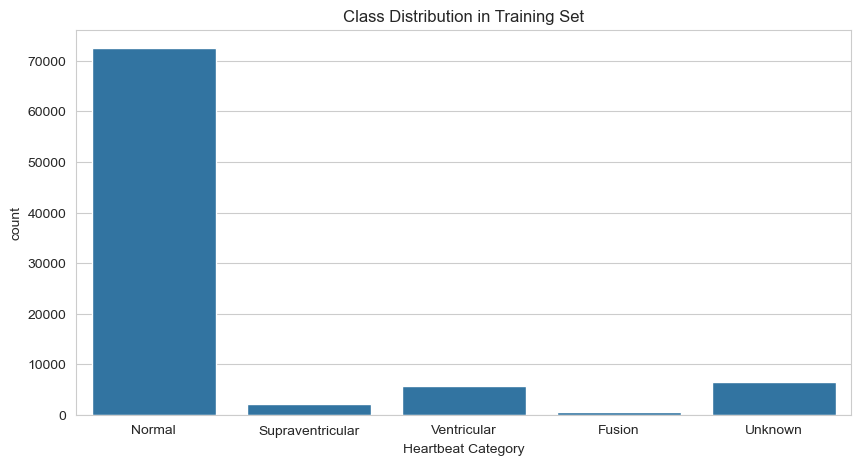

Class counts:
 187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [ ]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

label_names = {0: 'Normal', 1: 'Supraventricular', 2: 'Ventricular', 3: 'Fusion', 4: 'Unknown'}


plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Heartbeat Category")
plt.xticks(ticks=range(5), labels=[label_names[i] for i in range(5)])
plt.show()

print("Class counts:\n", y_train.value_counts())


-> The nornmal counts is around 11-13x times than the other class

Build model with gridsearchCV

In [ ]:
# take 10% -> for faster grid search
from sklearn.model_selection import train_test_split


X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.1, stratify=y_train, random_state=42)

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                
    scoring='f1_weighted', # optimize for class imba
    n_jobs=-1,           
    verbose=2
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


Eval

Test Accuracy: 0.9742

Classification Report:
                  precision    recall  f1-score   support

          Normal       0.97      1.00      0.99     18118
Supraventricular       0.95      0.60      0.74       556
     Ventricular       0.98      0.89      0.93      1448
          Fusion       0.82      0.61      0.70       162
         Unknown       1.00      0.95      0.97      1608

        accuracy                           0.97     21892
       macro avg       0.94      0.81      0.87     21892
    weighted avg       0.97      0.97      0.97     21892



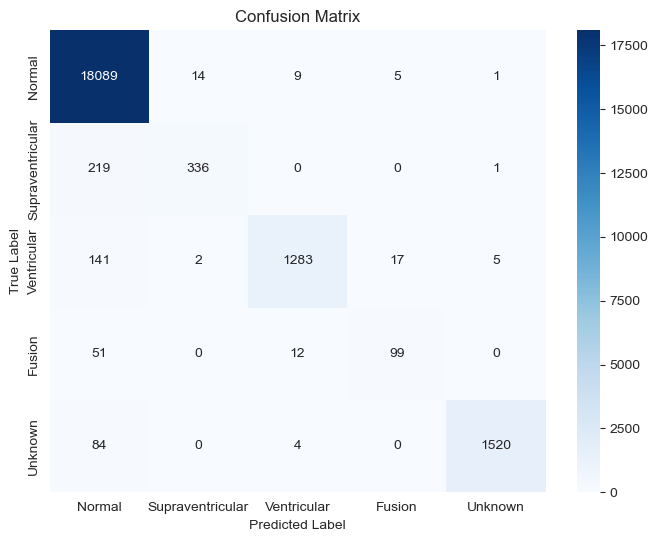

In [5]:
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[label_names[i] for i in range(5)]))

# confuse matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_names[i] for i in range(5)],
            yticklabels=[label_names[i] for i in range(5)])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()